Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 13.008s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.108s
Fitting the classifier to the training set


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationW

done in 22.420s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.065s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.71      0.87      0.78        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.91      0.86      0.88       146
Gerhard Schroeder       0.74      0.80      0.77        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.96      0.72      0.83        36

         accuracy                           0.81       322
        macro avg       0.76      0.76      0.75       322
     weighted avg       0.83      0.81      0.82       322


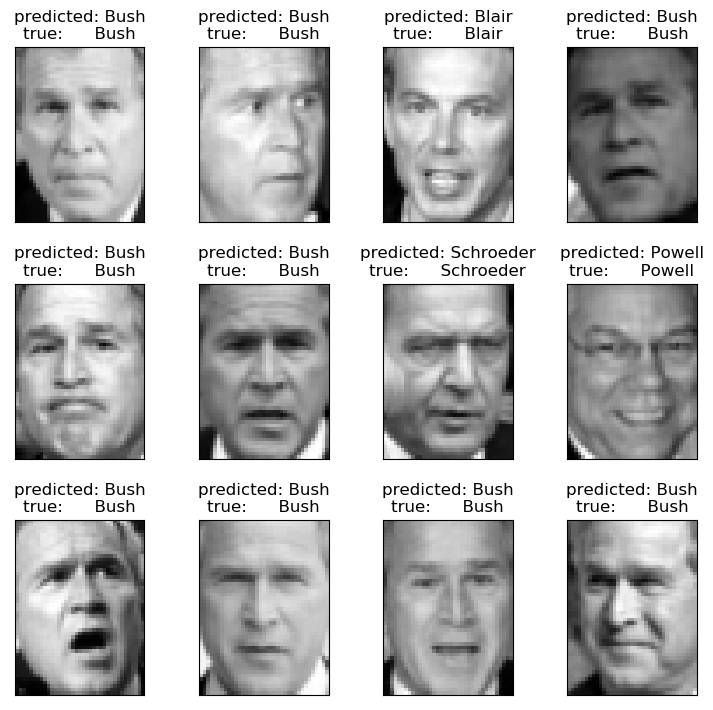

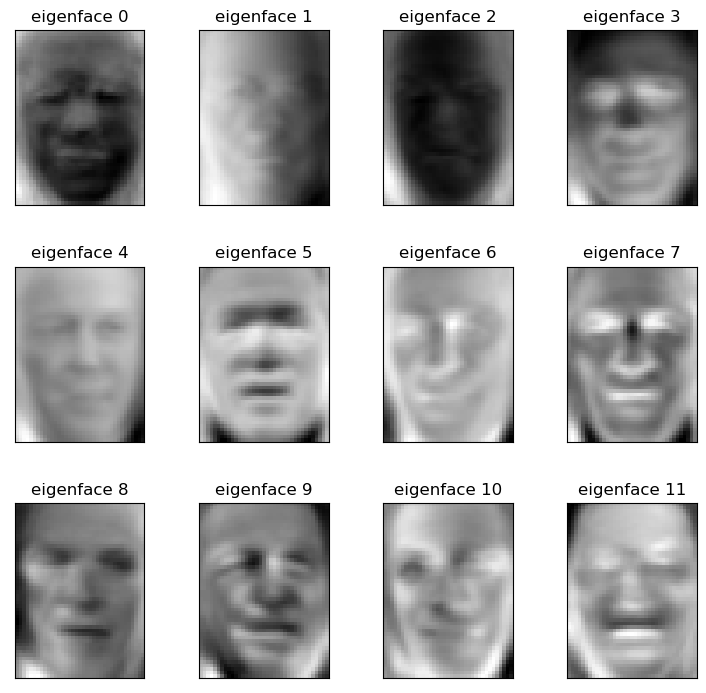

In [3]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s")


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 5e4, 1e5],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib


def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/datasets/base.py:241: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.empty((n_samples,), dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/datasets/base.py:245: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

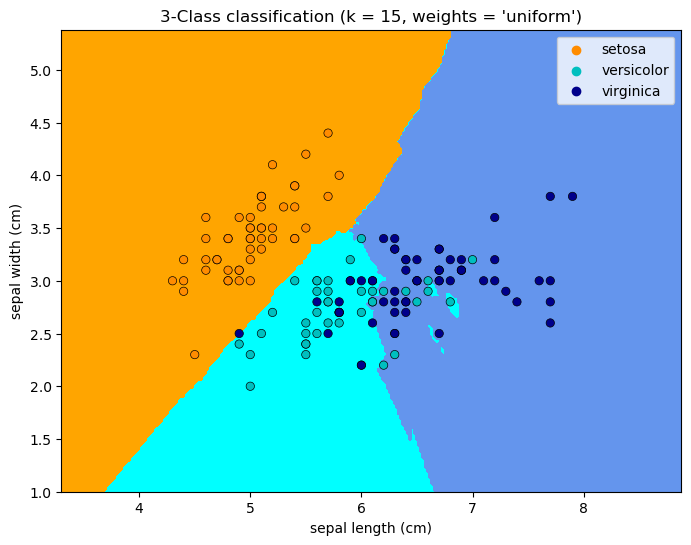

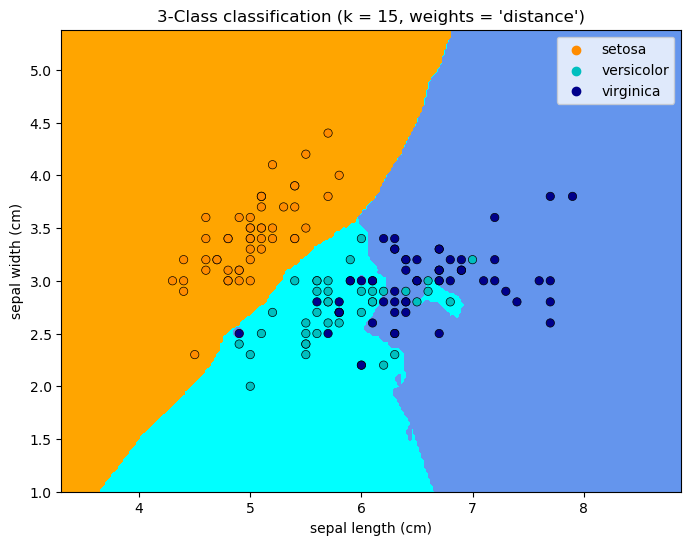

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

h = 0.02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for weights in ["uniform", "distance"]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, weights = '%s')" % (n_neighbors, weights)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()